In [35]:
# %pip install numpy
# %pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [48]:
def imgshow(name, img):
    cv2.imshow(name, img)
    cv2.moveWindow(name, 200, 200)
    cv2.waitKey(0)


img = cv2.imread('./images/IMG_0199.JPG')


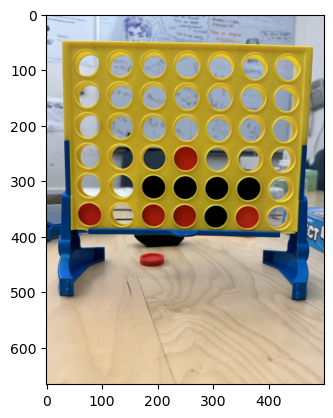

In [49]:
new_width = 500
img_h, img_w, _ = img.shape
scale = new_width / img_w
img_w = int(img_w * scale)
img_h = int(img_h * scale)
img = cv2.resize(img, (img_w, img_h), interpolation=cv2.INTER_AREA)
# Make a copy of the image
image_copy = np.copy(img)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

plt.imshow(image_copy)
plt.show()

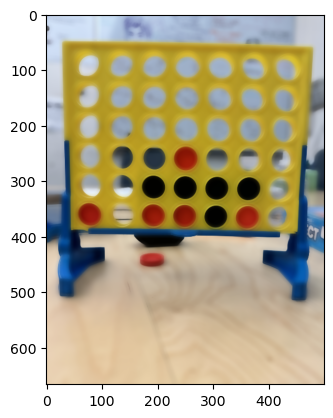

In [50]:
#Bilateral Filter

bilateral_filtered_image = cv2.bilateralFilter(image_copy, 15, 190, 190)
plt.imshow(bilateral_filtered_image)
plt.show()

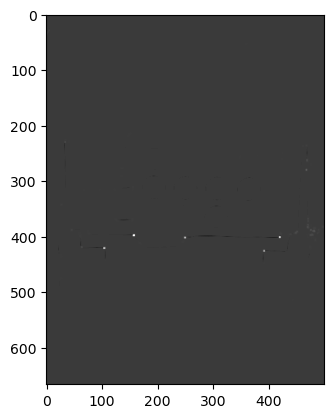

In [51]:

#Harris Corner Detection Algorithm: https://medium.com/@deepanshut041/introduction-to-harris-corner-detector-32a88850b3f6
# Convert to grayscale
gray = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

# Detect corners 
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)

plt.imshow(dst, cmap='gray')

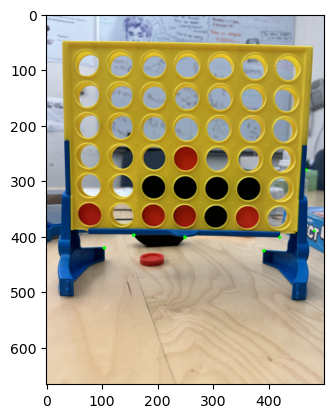

In [52]:
# This value vary depending on the image and how many corners you want to detect
# Try changing this free parameter, 0.1, to be larger or smaller and see what happens
thresh = 0.1*dst.max()

# Create an image copy to draw corners on
corner_image = np.copy(image_copy)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > thresh):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,0), 1)

plt.imshow(corner_image)

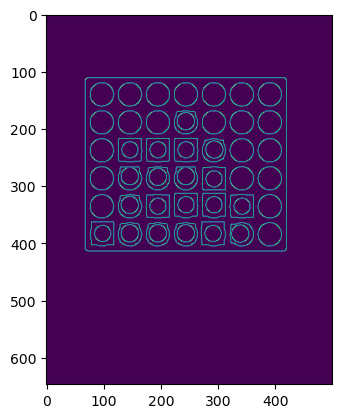

In [39]:
# Outline Edges
edge_detected_image = cv2.Canny(bilateral_filtered_image, 75, 150)
plt.imshow(edge_detected_image)
plt.show()

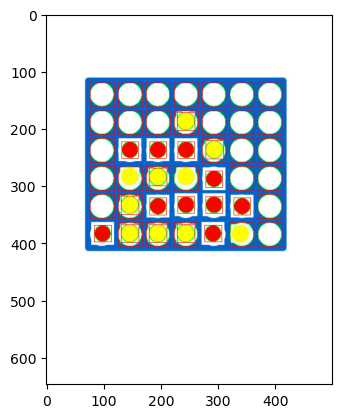

In [40]:
# Find Circles
contours, hierarchy = cv2.findContours(
    edge_detected_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_list = []
rect_list = []
position_list = []

for contour in contours:
    approx = cv2.approxPolyDP(
        contour, 0.01*cv2.arcLength(contour, True), True)
    area = cv2.contourArea(contour)

    rect = cv2.boundingRect(contour)
    x_rect, y_rect, w_rect, h_rect = rect
    x_rect += w_rect/2
    y_rect += h_rect/2
    area_rect = w_rect*h_rect

    if ((len(approx) > 8) & (len(approx) < 23) & (area > 250) & (area_rect < (img_w*img_h)/5)) & (w_rect in range(h_rect-10, h_rect+10)):  # Circle conditions
        contour_list.append(contour)
        position_list.append((x_rect, y_rect))
        rect_list.append(rect)

img_circle_contours = img_orig.copy()
cv2.drawContours(img_circle_contours, contour_list,  -1,
                 (0, 255, 0), thickness=1)  # Display Circles
for rect in rect_list:
    x, y, w, h = rect
    cv2.rectangle(img_circle_contours, (x, y), (x+w, y+h), (0, 0, 255), 1)

img_circle_contours_rgb = cv2.cvtColor(img_circle_contours, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.imshow(img_circle_contours_rgb)
plt.show()

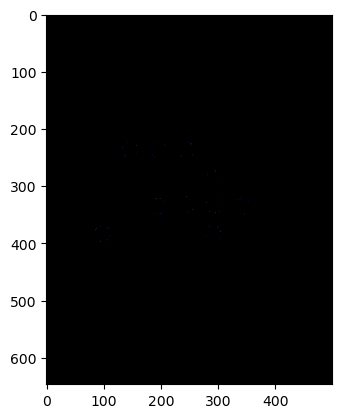

In [41]:

# Interpolate Grid
rows, cols = (6, 7)
mean_w = sum([rect[2] for r in rect_list]) / len(rect_list)
mean_h = sum([rect[3] for r in rect_list]) / len(rect_list)
position_list.sort(key=lambda x: x[0])
max_x = int(position_list[-1][0])
min_x = int(position_list[0][0])
position_list.sort(key=lambda x: x[1])
max_y = int(position_list[-1][1])
min_y = int(position_list[0][1])
grid_width = max_x - min_x
grid_height = max_y - min_y
col_spacing = int(grid_width / (cols-1))
row_spacing = int(grid_height / (rows - 1))

# Find Masks
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_red = np.array([150, 150, 100])
upper_red = np.array([255, 255, 255])
mask_red = cv2.inRange(img_hsv, lower_red, upper_red)
img_red = cv2.bitwise_and(img, img, mask=mask_red)

plt.imshow(img_red)
plt.show()

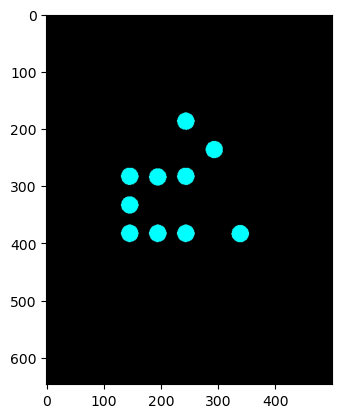

In [42]:

lower_yellow = np.array([10, 150, 100])
upper_yellow = np.array([60, 255, 255])
mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
img_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
plt.imshow(img_yellow)
plt.show()